## Importações

In [ ]:
!pip install ucimlrepo

In [ ]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from copy import deepcopy

from ucimlrepo import fetch_ucirepo
from IPython.display import clear_output

from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import silhouette_score, adjusted_rand_score

## Geração de dados

### UCI Machine Learning Repository

In [ ]:
ids = [545, 850, 697, 350, 94, 80, 544, 159, 468, 59]

MAX_QTD = 2000

uci_data = []

for id in tqdm(ids):
  row_data = fetch_ucirepo(id=id)

  continuous_columns = [row_data.variables.loc[i, "name"] for i in range(len(row_data.variables)) if row_data.variables.loc[i, "type"] in ["Continuous", "Integer"]]
  X = row_data.data.features

  X_selected = X[[col for col in X.columns if col in continuous_columns]]
  X_selected = X_selected.sample(n=min(MAX_QTD, len(X_selected)))

  y = row_data.data.targets
  y = LabelEncoder().fit_transform(np.squeeze(y.values))

  y = y[X_selected.index.tolist()]

  uci_data.append({
      "X": X_selected.values,
      "y": y,
      "n_features": X.shape[1],
      "n_classes": len(np.unique(y))
  })

100%|██████████| 10/10 [00:09<00:00,  1.07it/s]


In [ ]:
[print(len(data["X"]), data["n_features"], data["n_classes"]) for data in uci_data]

2000 7 2
900 7 2
2000 36 3
2000 23 2
2000 57 2
2000 64 10
2000 16 7
2000 10 2
2000 17 2
2000 16 26


[None, None, None, None, None, None, None, None, None, None]

### Toy datasets

In [ ]:
n_samples=2000
seed=36

toy_datasets = []

c1 = datasets.make_circles(
    n_samples=n_samples, factor=0.4, noise=0.05, random_state=seed
)
toy_datasets.append(c1)

c2 = datasets.make_circles(
    n_samples=(2*n_samples), factor=0.7, noise=0.05, random_state=2*seed
)
toy_datasets.append(c2)

m1 = datasets.make_moons(
    n_samples=n_samples, noise=0.05, random_state=seed
)
toy_datasets.append(m1)

m2 = datasets.make_moons(
    n_samples=n_samples, noise=0.15, random_state=2*seed
)
toy_datasets.append(m2)

b1 = datasets.make_blobs(
    n_samples=n_samples, random_state=seed
)
toy_datasets.append(b1)

b2_X, b2_y = datasets.make_blobs(
    n_samples=2*n_samples, random_state=3*seed
)
transformation = [[0.6, -0.9], [-0.2, 0.8]]
b2_X = np.dot(b2_X, transformation)
b2 = (b2_X, b2_y)
toy_datasets.append(b2)

b3 = datasets.make_blobs(
    n_samples=3*n_samples, random_state=2*seed, cluster_std=[1.0, 2.0, 0.5]
)
toy_datasets.append(b3)

b4_X, b4_y = datasets.make_blobs(
    n_samples=3*n_samples, random_state=5*seed, cluster_std=[1.1, 1.4, 0.5]
)
transformation = [[0.9, -0.6], [-0.2, 0.8]]
b4_X = np.dot(b4_X, transformation)
b4 = (b4_X, b4_y)
toy_datasets.append(b4)

b5 = datasets.make_blobs(
    n_samples=n_samples, random_state=10*seed, cluster_std=[2, 1.3, 0.7]
)
toy_datasets.append(b5)

rng=np.random.RandomState(seed)
no_cluster1 = rng.rand(n_samples, 2), np.zeros(n_samples)
toy_datasets.append(no_cluster1)

np.random.shuffle(toy_datasets)

aux = [
    {
        "X": c[0],
        "y": c[1],
        "n_features": 2,
        "n_classes": len(np.unique(c[1]))
    }
    for c in toy_datasets
]
toy_datasets = aux

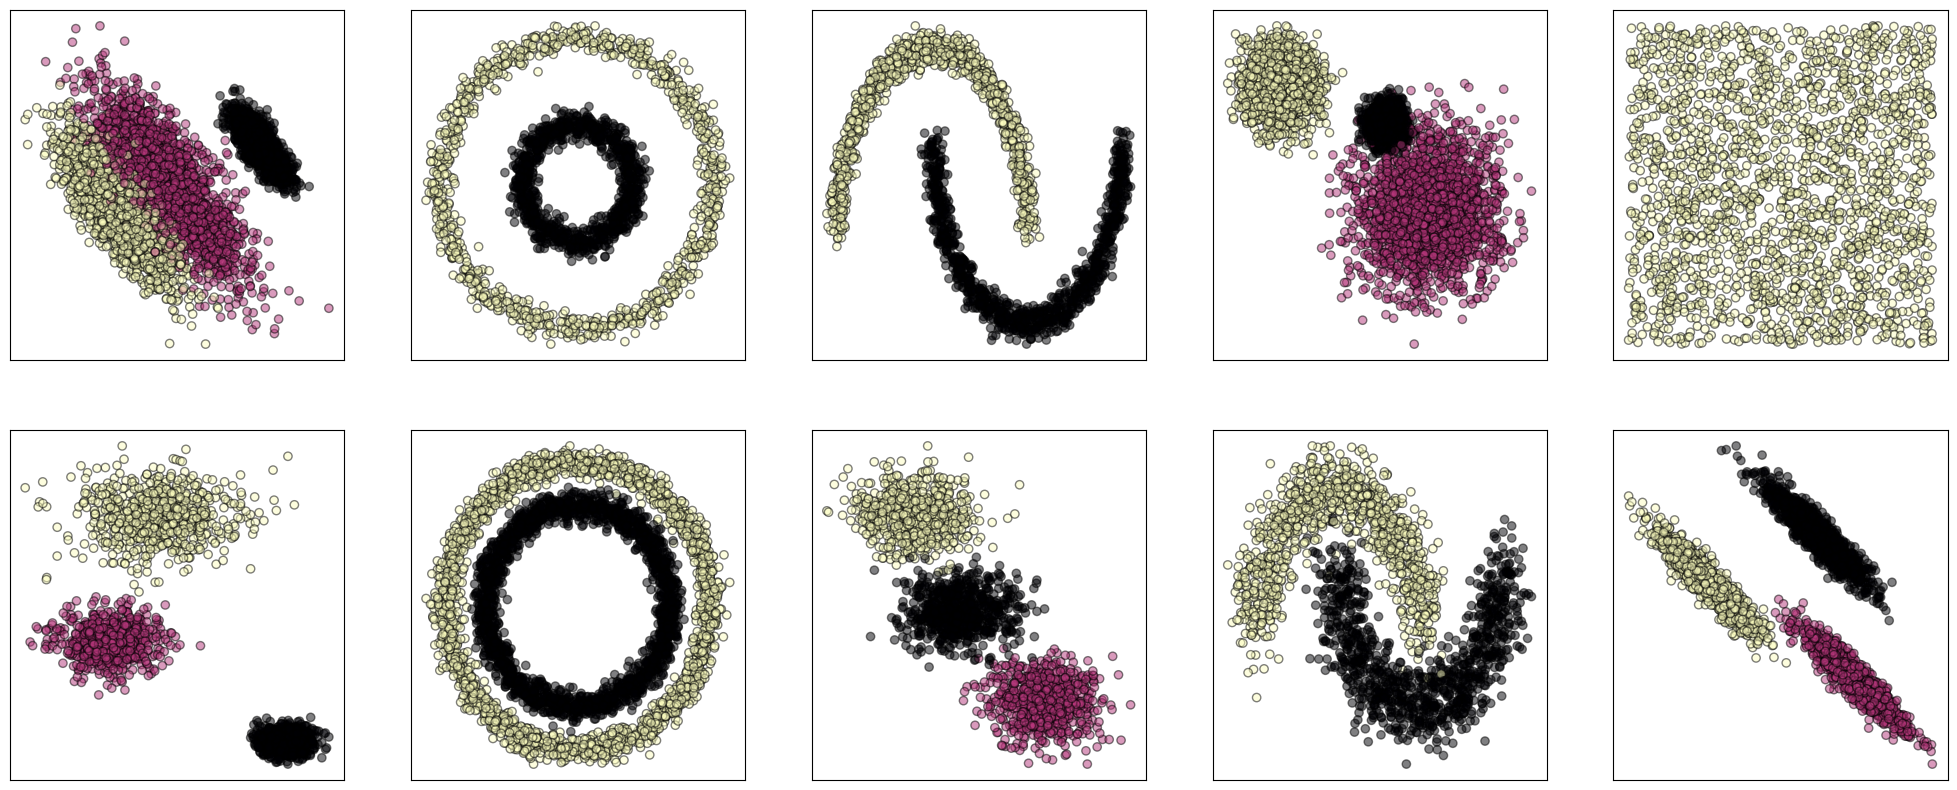

In [ ]:
dif_data = int(len(toy_datasets)/2)
fig, ax = plt.subplots(2, dif_data, figsize=(dif_data**2, 2*dif_data))
for i in range(2):
  for j in range(dif_data):
    classes = len(np.unique(toy_datasets[(i*5)+j]["y"]))
    x1 = toy_datasets[(i*5)+j]["X"][:, 0]
    x2 = toy_datasets[(i*5)+j]["X"][:, 1]
    y = toy_datasets[(i*5)+j]["y"]
    ax[i][j].scatter(
        x1,
        x2,
        c=y,
        cmap='magma_r',
        alpha=0.5,
        edgecolors='black'
    )
    ax[i][j].get_xaxis().set_visible(False)
    ax[i][j].get_yaxis().set_visible(False)

### Distribuição normal multivariada

In [ ]:
seed=42
n_sample=2000
multivariate_datasets = []
rng = np.random.default_rng(seed)

#amount of clusters to generate.
amount_of_clusters = [np.random.randint(2, 6) for _ in range(0,10)]

#mean for each cluster for an X data.
mean_list = []
for i in range(10):
  if (i%2==0):
    mean_list.append(((np.sum(np.random.randint(low=5, high=15, size=10))/10)*i)*np.random.rand(amount_of_clusters[i], 2))
  else:
    mean_list.append(((np.sum(np.random.randint(low=30, high=40, size=10))/10)*i)*np.random.rand(amount_of_clusters[i], 2))

#covariance matrix for each cluster for an X data.
cov_list = []
for i in range(10):
  all_cov = []
  for j in range(amount_of_clusters[i]):
    A = 10*np.random.rand(2,2)
    negative = np.random.rand()
    cov_m = (np.dot(A, A.transpose()))
    if (negative > 0.5):
      cov_m[0][1] = cov_m[1][0] = -1*cov_m[0][1]
    all_cov.append(cov_m)
  cov_list.append(all_cov)

#generating 10 pack of clusters, each cluster from a different distribution.
for i in range(10):
  am_of_cl = amount_of_clusters[i]
  X = []
  y = []
  for j in range(am_of_cl):
    mi = mean_list[i][j]
    c_m = cov_list[i][j]
    pts = rng.multivariate_normal(mi, c_m, size=n_sample)
    pts_label = np.array([j for _ in range(n_sample)])
    X.append(pts)
    y.append(pts_label)
  # print(am_of_cl)
  # print(np.array(X).shape)
  X = np.concatenate(X)
  y = np.concatenate(y)
  # print(X.shape)
  # print(y.shape)
  multivariate_datasets.append({
      "X":X,
      "y":y,
      "n_features": 2,
      "n_classes": am_of_cl
      })


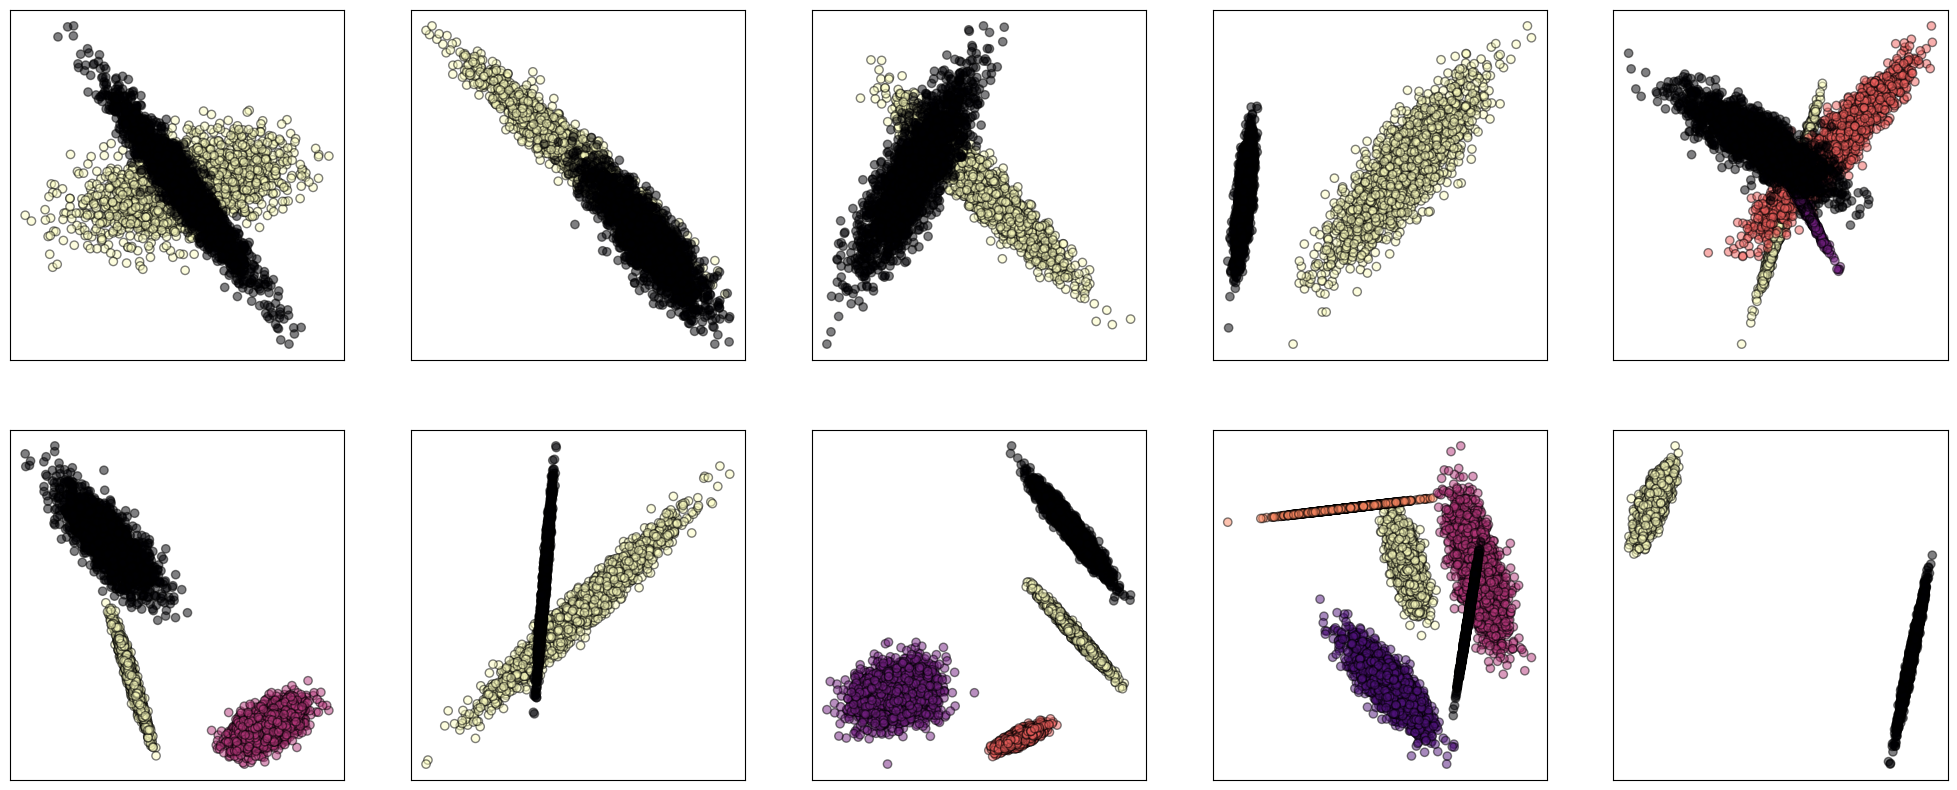

In [ ]:
#plotting each set of distributions.
dif_data = int(len(multivariate_datasets)/2)
fig, ax = plt.subplots(2, dif_data, figsize=(dif_data**2, 2*dif_data))
for i in range(2):
  for j in range(dif_data):
    classes = len(np.unique(multivariate_datasets[(i*5)+j]["n_classes"]))
    x1 = multivariate_datasets[(i*5)+j]["X"][:, 0]
    x2 = multivariate_datasets[(i*5)+j]["X"][:, 1]
    y = multivariate_datasets[(i*5)+j]["y"]
    ax[i][j].scatter(
        x1,
        x2,
        c=y,
        cmap='magma_r',
        alpha=0.5,
        edgecolors='black'
    )
    ax[i][j].get_xaxis().set_visible(False)
    ax[i][j].get_yaxis().set_visible(False)

## Algoritmos de K-centros

### Cálculo das matrizes de distância

In [ ]:
def vectorized_compute_matrix_distance(data):
  X = data["X"]

  m_d1 = np.abs(X[:, np.newaxis] - X).sum(axis=2)
  m_d2 = np.sqrt(np.sum((X[:, np.newaxis] - X) ** 2, axis=2))

  return m_d1, m_d2

### Primeira implementação

In [ ]:
def kcenters_1(points, k, ratio, dist_matrix):
  S = deepcopy(points)
  C = []

  while (len(S) > 0):
    s_pick = np.random.choice(S)
    S.remove(s_pick)

    grouped_by_s_pick = [point for point in S if dist_matrix[point][s_pick] <= (2*ratio)]
    S = [point for point in S if point not in grouped_by_s_pick]

    C.append(s_pick)

  return C if (len(C) <= k) else []

In [ ]:
def algorithm_with_refined_interval(points, k, dist_matrix, width_percent):
  max_distance = np.max(dist_matrix)
  ratio_left = 0
  ratio_right = max_distance

  C = kcenters_1(points, k, (ratio_right + ratio_left) / 2, dist_matrix)

  execs = 0
  while (ratio_right - ratio_left) > width_percent*max_distance or len(C) == 0:
    if len(C) > 0:
      ratio_right = (ratio_right + ratio_left) / 2
    else:
      ratio_left = (ratio_right + ratio_left) / 2

    C = kcenters_1(points, k, (ratio_right + ratio_left) / 2, dist_matrix)
    execs += 1

  return (ratio_right + ratio_left) / 2, C

## Segunda Implementação

In [ ]:
def kcenters_2(points, k, dist_matrix):
  S = deepcopy(points)

  if k > len(S):
    return S
  else:
    pick = np.random.choice(S)
    S.remove(pick)
    C = [pick]

  while len(C) < k:
    dist, point = max([min([(dist_matrix[center][point], point) for center in C]) for point in S])
    S.remove(point)
    C.append(point)
  return C

### KMeans

In [ ]:
def kmeans_algorithm(data):
  kmeans = KMeans(n_clusters=data["n_classes"], n_init="auto").fit(data["X"])

  return kmeans.cluster_centers_, kmeans.fit_predict(data["X"])

## Implementação

In [ ]:
n_samples = 15
results = []

In [ ]:
all_data = toy_datasets + uci_data + multivariate_datasets

In [ ]:
for idx, data in tqdm(enumerate(all_data)):
  print()
  m_d1, m_d2 = vectorized_compute_matrix_distance(data)

  k = data["n_classes"]
  points = list(range(len(data["X"])))

  for dist_matrix, distance in zip([m_d1, m_d2], ["manhattan", "euclidian"]):
    for interval in [0.01, 0.05, 0.1, 0.2, 0.25]:
      print(f"Algoritmo 1, distância de {distance} e intervalo {interval}")
      for l in range(n_samples // 3):
        tic = time.time()
        ratio, centers = algorithm_with_refined_interval(points, k, dist_matrix, interval)
        tac = time.time()

        labels = [np.argmin([dist_matrix[center][point] for center in centers]) for point in points]

        try:
          silhouette = silhouette_score(data["X"], labels)
        except ValueError:
          silhouette = -1

        results.append({
            "dataset": idx,
            "distance": distance,
            "algorithm": "1",
            "test": l,
            "interval": interval,
            "ratio": 2*ratio,
            "silhouette": silhouette,
            "rand_index": adjusted_rand_score(data["y"], labels),
            "time": tac-tic
        })

  for dist_matrix, distance in zip([m_d1, m_d2], ["manhattan", "euclidian"]):
    print(f"Algoritmo 2, distância de {distance}")
    for l in range(n_samples):
      tic = time.time()

      C = kcenters_2(points, k, dist_matrix)
      points_C = [point for point in points if point not in C]
      ratio = max([min([dist_matrix[center][point] for center in C]) for point in points_C])

      tac = time.time()

      labels = [np.argmin([dist_matrix[center][point] for center in C]) for point in points]

      try:
        silhouette = silhouette_score(data["X"], labels)
      except ValueError:
        silhouette = -1

      results.append({
        "dataset": idx,
        "distance": distance,
        "algorithm": "2",
        "test": l,
        "interval": np.nan,
        "ratio": ratio,
        "silhouette": silhouette,
        "rand_index": adjusted_rand_score(data["y"], labels),
        "time": tac-tic
      })

  for l in range(n_samples // 3):
    tic = time.time()
    centroids, labels = kmeans_algorithm(data)
    tac = time.time()

    ratio = np.max(np.linalg.norm(data["X"] - centroids[labels], axis=1))

    try:
      silhouette = silhouette_score(data["X"], labels)
    except ValueError:
      silhouette = -1

    results.append({
      "dataset": idx,
      "distance": "euclidian",
      "algorithm": "3",
      "test": l,
      "interval": np.nan,
      "ratio": ratio,
      "silhouette": silhouette,
      "rand_index": adjusted_rand_score(data["y"], labels),
      "time": tac-tic
    })

  pd.DataFrame(results).to_csv("results.csv", index=False)
  clear_output(wait=True)

In [ ]:
metrics = pd.read_csv("results.csv")

In [ ]:
from scipy import stats
import openpyxl

def mean_confidence_interval(data, confidence=0.95):
    mean = np.mean(data)
    sem = stats.sem(data)  # erro padrão da média
    h = sem * stats.t.ppf((1 + confidence) / 2., len(data) - 1)
    return mean, h

grouped = metrics[metrics["algorithm"] == 1].groupby(["dataset", "distance", "interval"])

field_metrics = ["time", "silhouette", "rand_index", "ratio"]

results = grouped.apply(lambda x: pd.Series({
    m: mean_confidence_interval(x[m])[0].round(3).astype(str) + " ± " + mean_confidence_interval(x[m])[1].round(2).astype(str)
    for m in field_metrics
}))

# Salvar o resultado em uma planilha Excel
results.reset_index().to_excel("resultado.xlsx", index=False, engine='openpyxl')

## Plots e Análises

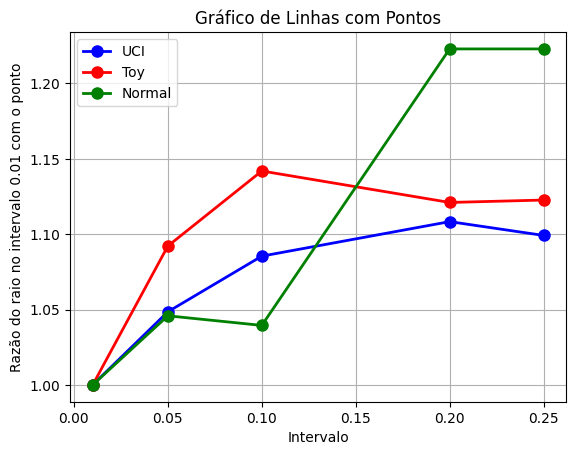

In [ ]:
results1 = metrics[(metrics["algorithm"] == 1) & (metrics["distance"] == "euclidian")].groupby(["dataset", "distance", "interval"]).mean()["ratio"]

for i in range(0, len(results1), 5):
  divide = results1.iloc[i]
  results1.iloc[i:i+5] /= divide

uci_result = results1.iloc[0:5].values
toy_result = results1.iloc[65:70].values
normal_result = results1.iloc[105:110].values

intervals = [0.01, 0.05, 0.1, 0.2, 0.25]

plt.plot(intervals, uci_result, marker='o', linestyle='-', color='b', markerfacecolor='b', markersize=8, linewidth=2, label="UCI")
plt.plot(intervals, toy_result, marker='o', linestyle='-', color='r', markerfacecolor='r', markersize=8, linewidth=2, label="Toy")
plt.plot(intervals, normal_result, marker='o', linestyle='-', color='g', markerfacecolor='g', markersize=8, linewidth=2, label="Normal")

plt.title('Gráfico de Linhas com Pontos')
plt.xlabel('Intervalo')
plt.ylabel('Razão do raio no intervalo 0.01 com o ponto')
plt.legend()
plt.grid()
plt.show()

### Silhueta e ARI

In [ ]:
silhouette_refined = metrics[(metrics["algorithm"] == 1 & (metrics["distance"] == "euclidian") & (metrics["interval"] == 0.01))].groupby(["dataset", "distance"]).mean()["silhouette"]
silhouette_maximized = metrics[(metrics["algorithm"] == 2) & (metrics["distance"] == "euclidian")].groupby(["dataset", "distance"]).mean()["silhouette"]
silhouette_kmeans = metrics[(metrics["algorithm"] == 3)].groupby(["dataset", "distance"]).mean()["silhouette"]

In [ ]:
ari_refined = metrics[(metrics["algorithm"] == 1 & (metrics["distance"] == "euclidian") & (metrics["interval"] == 0.01))].groupby(["dataset", "distance"]).mean()["rand_index"]
ari_maximized = metrics[(metrics["algorithm"] == 2) & (metrics["distance"] == "euclidian")].groupby(["dataset", "distance"]).mean()["rand_index"]
ari_kmeans = metrics[(metrics["algorithm"] == 3)].groupby(["dataset", "distance"]).mean()["rand_index"]

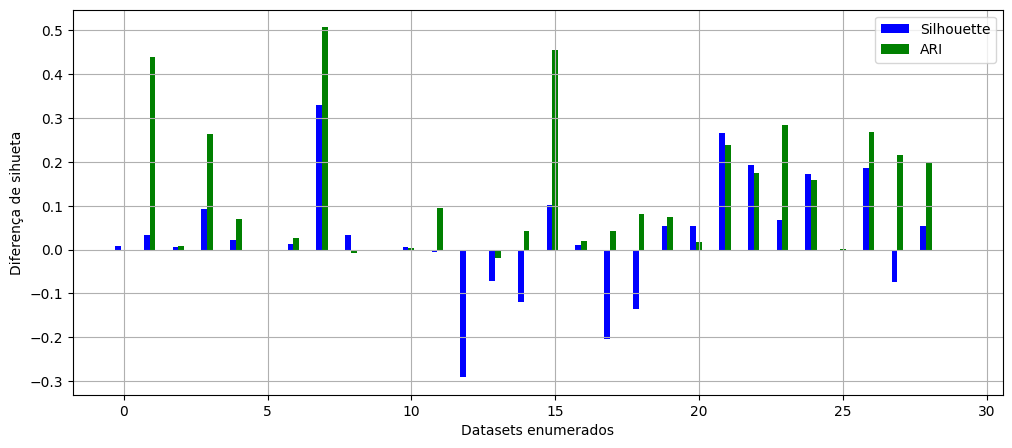

In [ ]:
df_silhouette = silhouette_kmeans - silhouette_maximized
df_ari = ari_kmeans - ari_maximized

indexs = list(range(len(df_silhouette)))
for r in [5, 9]: indexs.remove(r)

largura = 0.2
indexs = np.array(indexs)

fig, ax = plt.subplots(figsize=(12, 5))
bar1 = ax.bar(indexs - largura, df_silhouette.iloc[indexs].values, largura, label='Silhouette', color='b')
bar2 = ax.bar(indexs, df_ari.iloc[indexs].values, largura, label='ARI', color='g')

plt.xlabel("Datasets enumerados")
plt.ylabel("Diferença de sihueta")
plt.legend()
plt.grid()

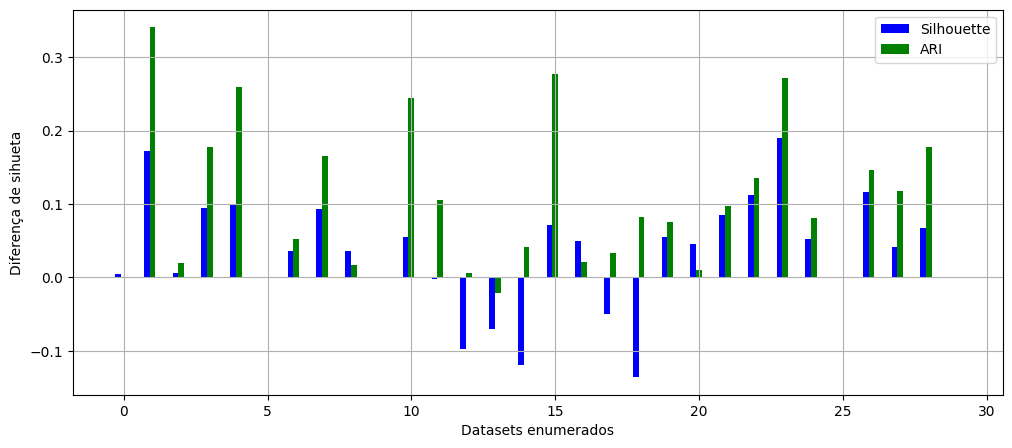

In [ ]:
df_silhouette = silhouette_kmeans - silhouette_refined
df_ari = ari_kmeans - ari_refined

indexs = list(range(len(df_silhouette)))
for r in [5, 9]: indexs.remove(r)

largura = 0.2
indexs = np.array(indexs)

fig, ax = plt.subplots(figsize=(12, 5))
bar1 = ax.bar(indexs - largura, df_silhouette.iloc[indexs].values, largura, label='Silhouette', color='b')
bar2 = ax.bar(indexs, df_ari.iloc[indexs].values, largura, label='ARI', color='g')

plt.xlabel("Datasets enumerados")
plt.ylabel("Diferença de sihueta")
plt.legend()
plt.grid()

### Análise de Tempo

In [ ]:
time_1 = metrics[(metrics["algorithm"] == 1) & (metrics["distance"] == "euclidian") & (metrics["interval"] == 0.01)].groupby(["dataset", "distance", "interval"]).mean()["time"]
time_2 = metrics[(metrics["algorithm"] == 2) & (metrics["distance"] == "euclidian")].groupby(["dataset", "distance"]).mean()["time"]
time_3 = metrics[(metrics["algorithm"] == 2) & (metrics["distance"] == "euclidian")].groupby(["dataset", "distance"]).mean()["time"]

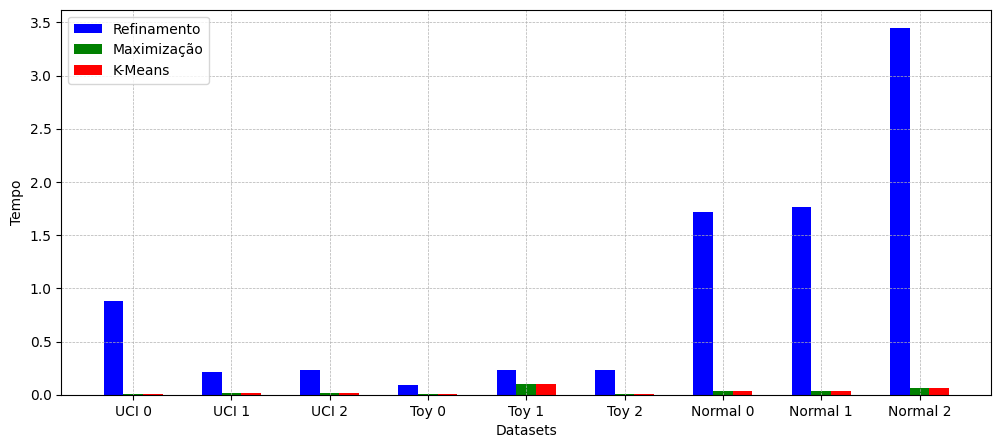

In [ ]:
labels = ["UCI 0", "UCI 1", "UCI 2", "Toy 0", "Toy 1", "Toy 2", "Normal 0", "Normal 1","Normal 2"]

conjunto1 = [time_1.iloc[0], time_1.iloc[2], time_1.iloc[4], time_1.iloc[11], time_1.iloc[15], time_1.iloc[17],time_1.iloc[20], time_1.iloc[25], time_1.iloc[27]]
conjunto2 = [time_2.iloc[0], time_2.iloc[2], time_2.iloc[4], time_2.iloc[11], time_2.iloc[15], time_2.iloc[17],time_2.iloc[20], time_2.iloc[25], time_2.iloc[27]]
conjunto3 = [time_3.iloc[0], time_3.iloc[2], time_3.iloc[4], time_3.iloc[11], time_3.iloc[15], time_3.iloc[17],time_3.iloc[20], time_3.iloc[25], time_3.iloc[27]]

n = len(labels)
x = np.arange(n)
largura = 0.2

fig, ax = plt.subplots(figsize=(12, 5))
bar1 = ax.bar(x - largura, conjunto1, largura, label='Refinamento', color='b')
bar2 = ax.bar(x, conjunto2, largura, label='Maximização', color='g')
bar3 = ax.bar(x + largura, conjunto3, largura, label='K-Means', color='r')

# Adicionando rótulos e título
ax.set_xlabel('Datasets')
ax.set_ylabel('Tempo')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Adicionando grade
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Exibindo o gráfico
plt.show()

### Comparativo de distâncias

In [175]:
metrics[(metrics["algorithm"] == 2) & (metrics["distance"] == "euclidian")].groupby(["dataset", "distance"]).mean()["ratio"].iloc[[0, 5, 10, 15, 20, 25]]

,,ratio
dataset,distance,
0,euclidian,1.549322
5,euclidian,1.065638
10,euclidian,6495.367964
15,euclidian,50.663381
20,euclidian,27.094537
25,euclidian,80.932710


## Exemplo prático

In [199]:
data = multivariate_datasets[1]

m_d1, m_d2 = vectorized_compute_matrix_distance(data)

In [200]:
k = data["n_classes"]
y = data["y"]
points = list(range(len(data["X"])))

ratio1, centers1 = algorithm_with_refined_interval(points, k, m_d2, 0.01)
labels1 = [np.argmin([m_d2[center][point] for center in centers1]) for point in points]

centers2 = kcenters_2(points, k, m_d2)
points_C = [point for point in points if point not in centers2]
ratio = max([min([m_d2[center][point] for center in centers2]) for point in points_C])

labels2 = [np.argmin([m_d2[center][point] for center in centers2]) for point in points]

centroids, labels3 = kmeans_algorithm(data)

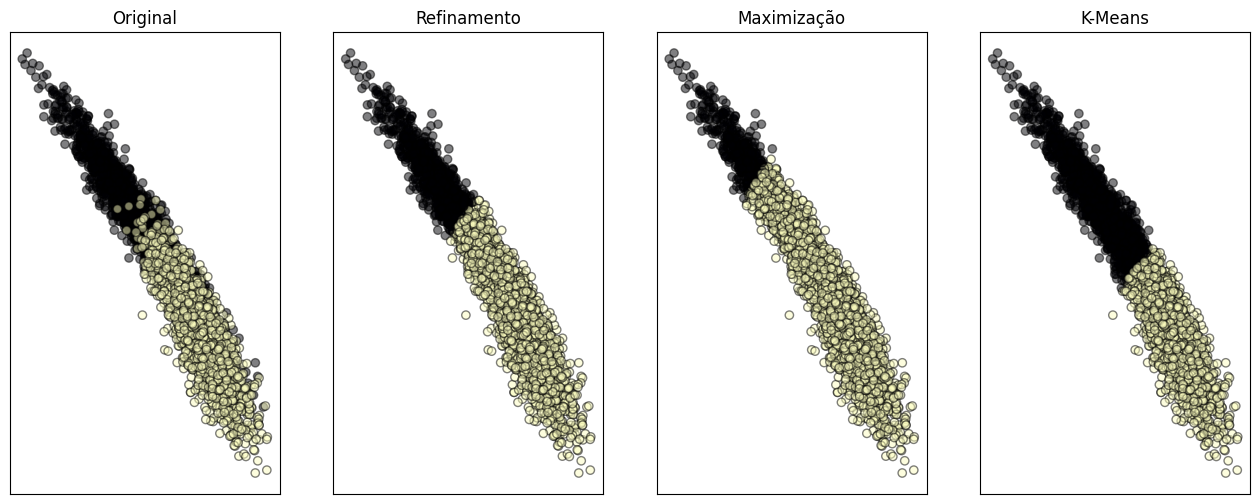

In [202]:
fig, axis = plt.subplots(1, 4, figsize=(16, 6))

x1 = data["X"][:, 0]
x2 = data["X"][:, 1]

d = {0:1, 1:0}

axis[0].scatter(
        x1,
        x2,
        c=[d[yi] for yi in y],
        cmap='magma_r',
        alpha=0.5,
        edgecolors='black'
    )
axis[0].get_xaxis().set_visible(False)
axis[0].get_yaxis().set_visible(False)
axis[0].set_title("Original")

axis[1].scatter(
        x1,
        x2,
        c=labels1,
        cmap='magma_r',
        alpha=0.5,
        edgecolors='black'
    )
axis[1].get_xaxis().set_visible(False)
axis[1].get_yaxis().set_visible(False)
axis[1].set_title("Refinamento")

axis[2].scatter(
        x1,
        x2,
        c=labels2,
        cmap='magma_r',
        alpha=0.5,
        edgecolors='black'
    )
axis[2].get_xaxis().set_visible(False)
axis[2].get_yaxis().set_visible(False)
axis[2].set_title("Maximização")

axis[3].scatter(
        x1,
        x2,
        c=labels3,
        cmap='magma_r',
        alpha=0.5,
        edgecolors='black'
    )

axis[3].get_xaxis().set_visible(False)
axis[3].get_yaxis().set_visible(False)
axis[3].set_title("K-Means")

plt.show()